# Kiinteistöjen hinnan ennustaminen
### Syväoppiminen harjoitustyö
### Petteri Stjerna / aa3729

# Johdanto

[Dataset-lähde](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview)

Aineistoon on tallennettu useita taloa kuvaavia piirteitä ja talon myyntihinta. Tavoitteena on pyrkiä ennustamaan mahdollisimman hyvin myyntihinta piirteiden avulla. Harjoituksessa käytetään kahta mallia, XGBoost-regressoria ja MLP-regressoria. XGBoost-regressorin on todettu suoriutuvan hyvin useista koneoppimisongelmista, joten se otettiin tähän tuomaan vertailuarvoja syväoppimismallia vastaan. MLP-regressori valittiin syväoppimismalliksi, koska sitä käytetään yleisesti ja on myös hyvin suoriutuva.

Aineisto sisältää 79 piirrettä kahdessa tiedostossa, train.csv (1460 riviä) ja test.csv (1459 riviä). Harjoituksessa käytetään pääasiallisesti train-tiedostoa, koska test-tiedosto ei sisällä kohdepiirrettä eli myyntihintaa. Koska data on saatu Kagglen kilpailusta, test-tiedostosta saadut ennusteet on tarkoitus syöttää Kagglen sivustolle, joka laskee pisteet ja syöttää ne julkiseen pistetaulokkoon automaattisesti. Tämä vaihe tehtiin harjoituksen lopussa, jotta mallin suoriutumiseen saatiin huomattavasti enemmän vertailuarvoja.

[Vinkkejä](https://www.kaggle.com/code/gusthema/house-prices-prediction-using-tfdf/notebook)

# Koodikirjastojen importtaus ja apufunktioiden luonti

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, ColumnTransformer, make_column_selector
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_squared_log_error

# Apufunktioita
def Calculate_scores(true, pred, verbose=True):
    r2 = r2_score(true, pred)
    rmse = mean_squared_error(true, pred, squared=False)
    rmsle = mean_squared_log_error(true, pred, squared=False)
    mae = mean_absolute_error(true, pred)
    print("r^2: ", r2)
    print("rmse :", rmse)
    print("rmsle :", rmsle)
    print("mae :", mae)
    #Plot_result(true, pred)
    return r2, rmse, rmsle, mae

def Plot_result(true, pred):
    a = plt.axes(aspect='equal')
    plt.scatter(true, pred)
    plt.xlabel('Oikeat arvot')
    plt.ylabel('Ennustus')
    lims = [5, 15]
    plt.xlim(lims)
    plt.ylim(lims)
    plt.title("Ennustus/oikeat arvot")
    plot = plt.plot(lims, lims)
    plt.show()
    return plot

def floorfeature(X):
    X['Has2ndFloor'] = X['2ndFlrSF'].apply(lambda x: 0 if x == 0 else 1)
    return X
    

# Aineiston lukeminen tiedostosta

In [43]:
dir = 'house-prices-advanced-regression-techniques'

train_data = pd.read_csv(dir + '/train.csv', header=0)

# Poistetaan Id-piirre
train_data = train_data.drop(columns='Id')

train_data.head()

#with pd.option_context("display.max_columns", 500):
#    print(train_data[train_data['LotFrontage'].isna()].head())

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave   NaN      Reg   
1          20       RL         80.0     9600   Pave   NaN      Reg   
2          60       RL         68.0    11250   Pave   NaN      IR1   
3          70       RL         60.0     9550   Pave   NaN      IR1   
4          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
0         Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
1         Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   
2         Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
3         Lvl    AllPub    Corner  ...        0    NaN   NaN         NaN   
4         Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
0       0      2    2008        WD         Normal     208500  
1       0      5    2007        WD         Normal     181500  
2       0      9    2008        WD         Normal     223500  
3       0      2    2006        WD        Abnorml     140000  
4       0     12    2008        WD         Normal     250000  

[5 rows x 80 columns]

# Visualisointeja

Tarkastellaan aineiston rakennetta.

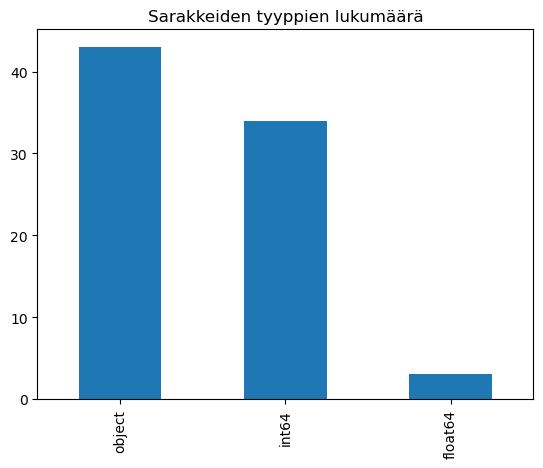

In [44]:
train_data.dtypes.value_counts().plot.bar()
plt.title("Sarakkeiden tyyppien lukumäärä");

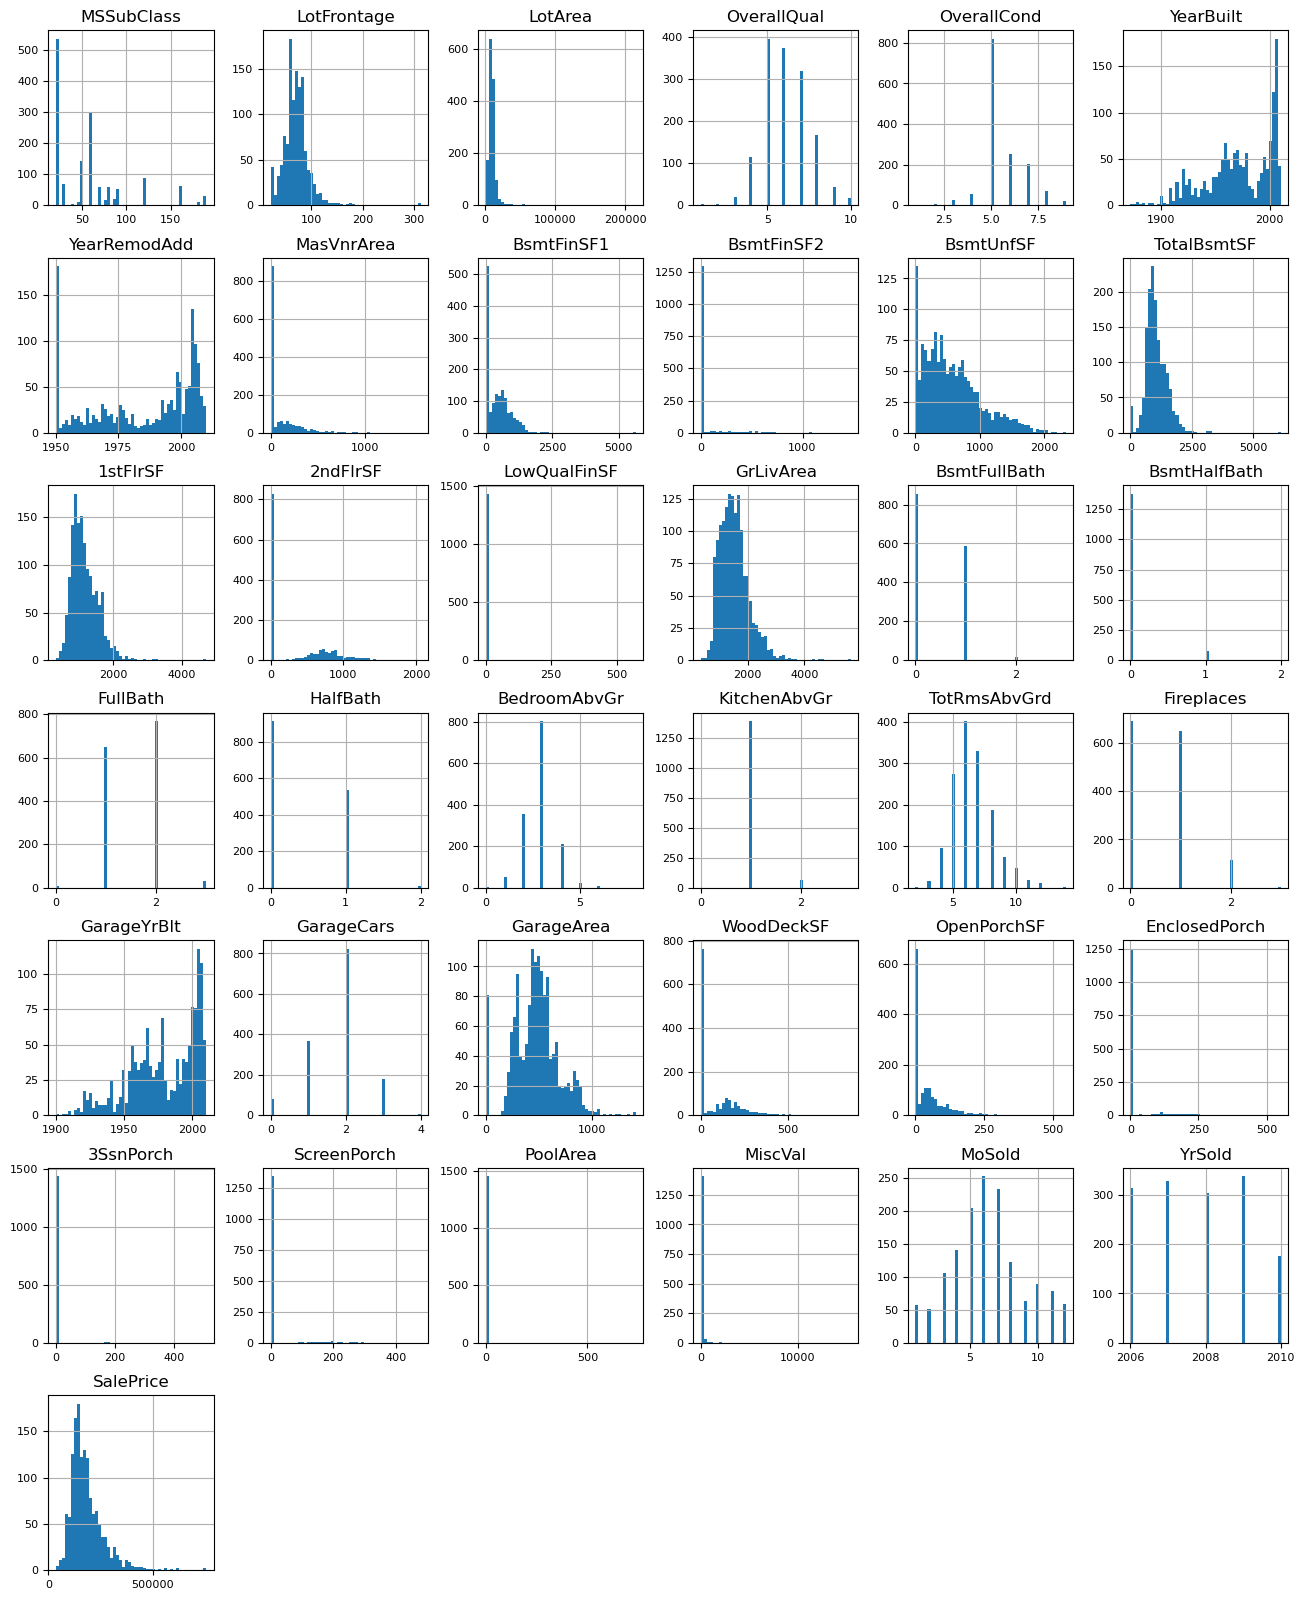

In [45]:
numerical_data = train_data.select_dtypes(include=['int64','float64'])
numerical_data.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)
plt.title("Numeeristen arvojen jakauma");

Aineistossa on paljon kategorisia piirteitä, jotka pitää muuttaa numeeriksi tai poistaa.

Numeerisissa arvoissa jakaumat näyttävät hyviltä, mutta muutamissa tapauksissa näkyy huomattavan korkeita arvoja, jotka voisi lukea outliereiksi. Lisäksi monet piirteet sisältävät huomattavan suuria määria nolla-arvoja, mikä yleensä tarkoittaa että kyseistä ominaisuutta ei ole talossa. Näille piirteille on usein tukena kategorinen muuttuja, joka kertoo ominaisuuden tyypin ja onko sitä olemassa.   

# Puuttuvien arvojen käsittely

Puuttuva arvo kategorisissa muuttujissa tarkoittaa yleensä, että kyseistä ominaisuutta ei ole talossa.

Esimerkiksi jos 'fence' on NA, talossa ei ole aitaa. Muuten sarake kertoo aidan tyypin/laadun.


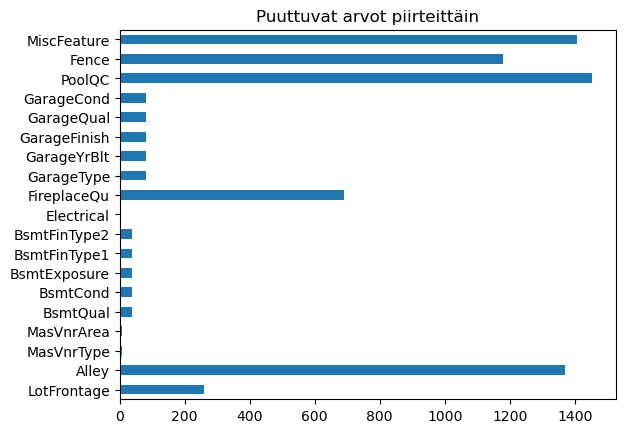

In [46]:
missing_values = train_data.isna().sum()
missing_values[missing_values != 0].plot.barh()
plt.title('Puuttuvat arvot piirteittäin')
plt.show()
#print(train_data['MasVnrType'].unique())

LotFrontage, MasVnrType, MasVnrArea ja Electrical -piirteiden puuttuvista arvoista ei ole mainittu lähtötiedoissa, joten käsitellään ne ensin.

LotFrontage on kiinteistön yhteydessä olevan tien määrä jaloissa mitattuna. Oletetaan, että puuttuvat arvot tarkoittaa nollaa.

MasVnrType, MasVnrArea. MasVnrTypellä on erikseen None arvo annettu, joten NA on varmaankin oikeasti puuttuva arvo. Korvataan Type yleisimmällä arvolla ja Area mediaanilla.

Electrical korvataan yleisimmällä arvolla


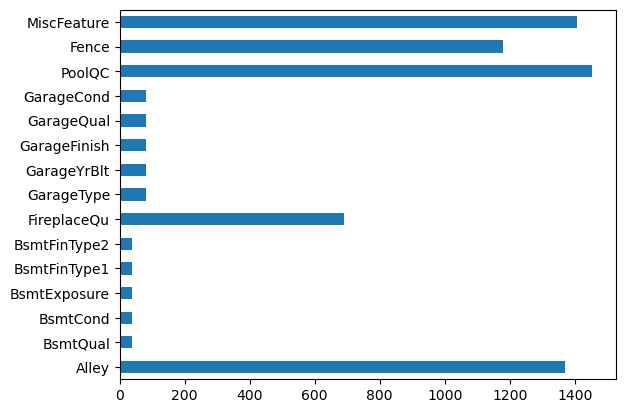

In [47]:
df = train_data.copy()

# LotFrontage on kiinteistön yhteydessä olevan tien määrä jaloissa mitattuna. Oletetaan, että puuttuvat arvot tarkoittaa nollaa.
df['LotFrontage'] = df['LotFrontage'].fillna(0)

# MasVnrType, MasVnrArea. MasVnrTypellä on erikseen None arvo annettu, joten Na on varmaankin puuttuva. Korvataan Type yleisimmällä arvolla ja Area mediaanilla.
df['MasVnrArea'] = df['MasVnrArea'].fillna(df['MasVnrArea'].median())
df['MasVnrType'] = df['MasVnrType'].value_counts().index[0]

# Electrical korvataan yleisimmällä arvolla
df['Electrical'] = df['Electrical'].value_counts().index[0]

missing_values = df.isna().sum()
missing_values[missing_values != 0].plot.barh()
plt.show()

# Kategoristen arvojen käsittely

Loput puuttuvat arvot ovat kategorisissa sarakkeissa paitsi GarageYrBlt

In [48]:
# Käsitellään loput piirteet

# GarageYrBlt:n puuttuvat arvot korvataan mediaanilla
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(df['GarageYrBlt'].median())

# Loput ovat kategorisia piirteitä. Muunnetaan ne numeerisiksi,
categorical_columns = df.select_dtypes(include=['object']).columns
print(categorical_columns)

df = pd.concat(
    [df, pd.get_dummies(df[categorical_columns], dtype=float)],
    axis=1 
).drop(columns=categorical_columns)

print(df.info())

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 282 entries, MSSubClass to SaleCondition_Partial
dtypes: float64(248), int64(34)
memory usage: 3.1 MB
None


In [49]:
print('Puuttuvia arvoja')
print(df.isna().sum().sum())

Puuttuvia arvoja
0


# Uusien piirteiden luonti

In [50]:
# GarageYrBlt on ongelmallinen, sillä puuttuvia arvoja on niin monta, että niitä ei voi yksinkertaisesti korvata millään ilman että se vaikuttaa aineistoon.
# Autotallin olemassaolo on kerrottu jo GarageType-sarakkeessa, joten poistetaan GarageYrBlt-sarake. Tehdään sen sijaan uusi sarake GarageBltLater, joka kertoo onko autotalli rakennettu jälkikäteen.


#df['GarageBltLater'] = df.apply(
#    lambda x: 1 if x['GarageYrBlt'] > x['YearBuilt'] else 0, axis=1)
#df[['YearBuilt', 'GarageYrBlt', 'GarageBltLater']].head()
#df = df.drop(columns='GarageYrBlt')

# Voisi kenties lisätä myös sarakkeen, joka kertoo kuinka paljon uudempi autotalli

# Kommentoitu sarakkeenlisäys pois, koska se vaikutti negatiivisesti ennustukseen

Aineistossa on annettu ensimmäisen ja toisen kerroksen asuinpinta-ala. Luodaan uusi piirre, joka kertoo onko talossa yksi vai kaksi kerrosta.  

In [51]:
df['Has2ndFloor'] = df['2ndFlrSF'].apply(lambda x: 0 if x == 0 else 1)
df[['Has2ndFloor','2ndFlrSF']].head()



Has2ndFloor  2ndFlrSF
0            1       854
1            0         0
2            1       866
3            1       756
4            1      1053

# Toteutus

# XGB-Regressor mallin luominen ja ennustaminen
Lasketaan malleista r2, rmse sekä mae arviointia varten.

Kaggle käyttää lisäksi rmsle:tä (root median squared logarithmic error) eli melkein sama kuin rmse, mutta virheet on ensin muunnettu logaritmin avulla. Tämä vähentää poikkeamien vaikutusta tulokseen.

In [52]:
# Käytetään tässä vaiheessa koko datasettiä sen pilkkomiseen sijaan, 
# jotta saadaan jonkinlainen kuva datan toimivuudesta esimerkkimallilla 

X = df.drop(columns='SalePrice')
y = df['SalePrice']

model = XGBRegressor().fit(X, y)
y_pred = pd.DataFrame(
    model.predict(X),
)

Calculate_scores(y, y_pred)

figsize = (13, 4)
fig, ax = plt.subplots(figsize=figsize)

y_pred.plot(ax=ax)
y.plot(ax=ax)
ax.legend(["Ennuste", "Oikea"])
ax.set(xlim=[400, 500])
plt.title("XGB-Regressori kaikki data")
plt.show()

r^2:  0.9994709562408484
rmse : 1826.6272584651629
rmsle : 0.012084697457603615
mae : 1304.5203071489725


Hyvin toimii

# Aineiston pilkkominen

Tehdään sama, kuin edellisessä vaiheessa, mutta pilkotaan data ja käytetään pipelineä hyväksi

Jaetaan data train ja test osiksi alussa, jotta vältytään datan vuotamiselta.

Aineistossa on annettu erikseen test.csv, mutta se ei sisällä kohdemuuttujan eli SalePricen arvoja, 
joten sitä ei käytetä tässä vaiheessa.

(Testi-datan hyvyyttä on tarkoitus arvioida Kagglen sivustolla heidän omalla leaderboardillaan)

In [53]:
print(f'Kaikki data: {len(train_data)}')

X = train_data.drop(columns='SalePrice')
y = train_data['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=0) 

print(f'Train-data: {len(X_train)} Test-data: {len(X_test)}')

# Resetoidaan vielä indexit
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

Kaikki data: 1460
Train-data: 1168 Test-data: 292


# Pipeline XGBoost-regressorilla

[Vinkkejä pipelineen ja sklearns esikäsittelyyn](https://marloz.github.io/projects/sklearn/pipeline/missing/preprocessing/2020/03/20/sklearn-pipelines-missing-values.html)

Toisin kuin aikaisemmin, korvataan kaikki puuttuvat numeeriset arvot mediaanilla.

Puuttuvia kategorisia arvoja ei korvata yleisimmällä arvolla, vaan NA-arvot muunnetaan tarkoittamaan, 
että ominaisuus ei kuulu mihinkään kategoriaan

Nämä muutokset siitä syystä, että saadaan yksinkertaistettua prosessia pipelineä varten.


In [54]:
# Numeeriset piirteet
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Kategoriset piirteet
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Piirteiden valinta eri käsittelyputkille
preprocessor = ColumnTransformer(
    transformers=[
        #('addfloor', FunctionTransformer(floorfeature, validate=False, feature_names_out='one-to-one'), ['2ndFlrSF']),
        ('numerical', numeric_transformer, make_column_selector(dtype_include=np.number)),
        ('categorical', categorical_transformer, make_column_selector(dtype_include=object)),
    ])

# Lopullinen pipeline
reg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor',  XGBRegressor())])

reg.fit(X, y)

# Piirteiden nimet talteen
column_names = reg[:1].get_feature_names_out()
print(f'Piirteitä {len(column_names)}')

#ff = FunctionTransformer(floorfeature, validate=False, feature_names_out='one-to-one').set_output(transform="pandas")
#ff.fit_transform(X)[['Has2ndFloor', '2ndFlrSF']]

Piirteitä 304


In [55]:
y_pred = pd.DataFrame(
    reg.predict(X)
)

Calculate_scores(y, y_pred)

figsize = (13, 4)
fig, ax = plt.subplots(figsize=figsize)

y_pred.plot(ax=ax)
y.plot(ax=ax)
ax.legend(["Ennuste", "Oikea"])
ax.set(xlim=[400, 500])
plt.title("XGB-regressori pipelinessä kaikella datalla")
plt.show()

r^2:  0.9994999033152582
rmse : 1775.9515936253963
rmsle : 0.011969743343103793
mae : 1257.2875508347602


Tulokset ovat hieman parempia kuin ilman pipelineä. Tähän syynä lienee datan normalisointi.

# Pipeline XGB-regressorilla train datalla

Katsotaan kuinka hyvin sovittuu opetusaineistoon.

In [56]:
# Näyttäisi toimivan. Tehdään nyt sama mutta käytetään hyväksi train ja test data settejä

# Pipelineä ei tarvitse rakentaa uudelleen
reg.fit(X_train, y_train)

column_names = reg[:1].get_feature_names_out()

r^2:  0.9996867747880813
rmse : 1394.296342162578
rmsle : 0.00977941169623475
mae : 996.2041049068921


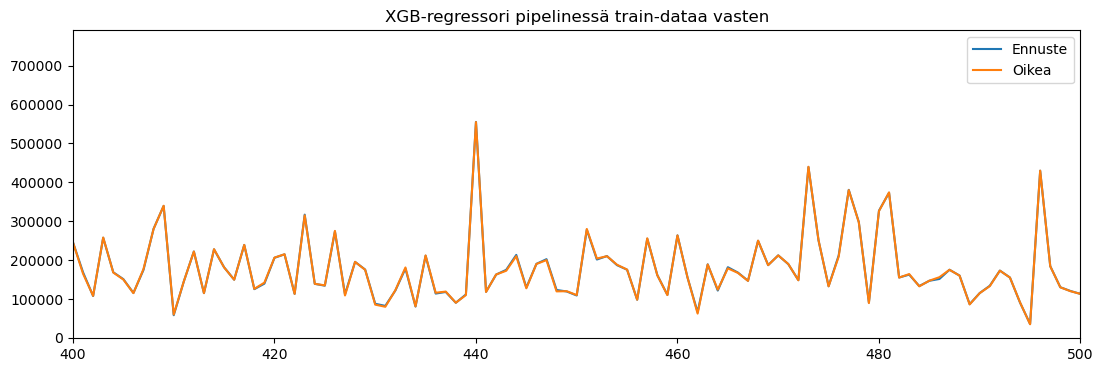

In [57]:
y_pred = pd.DataFrame(
    reg.predict(X_train)
)

Calculate_scores(y_train, y_pred)

figsize = (13, 4)
fig, ax = plt.subplots(figsize=figsize)

y_pred.plot(ax=ax)
y_train.plot(ax=ax)
ax.legend(["Ennuste", "Oikea"])
ax.set(xlim=[400, 500])
plt.title("XGB-regressori pipelinessä train-dataa vasten")
plt.show()

Tulokset paranivat, vaikka käytettävän datan määrä pieneni.

# Pipeline XGB-regressorilla test-datalla

Katsotaan kuinka hyvin sovittuu testausaineistoon

r^2:  0.8678611731777475
rmse : 29766.418360341875
rmsle : 0.1372691608433203
mae : 17104.56843964041


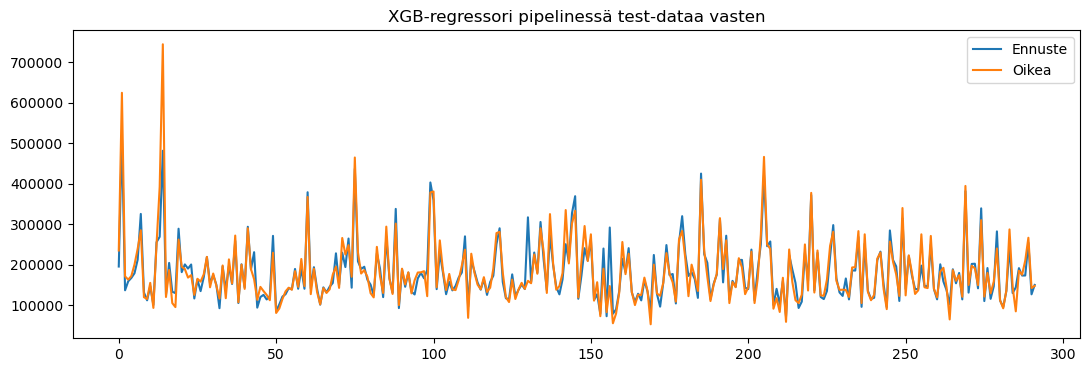

r^2:  0.8678611731777475
rmse : 29766.418360341875
rmsle : 0.1372691608433203
mae : 17104.56843964041


In [58]:
# Entäpä test-datalla?
# Malli on valmiiksi fitattu
y_pred = pd.DataFrame(
    reg.predict(X_test)
)

Calculate_scores(y_test, y_pred)

figsize = (13, 4)
fig, ax = plt.subplots(figsize=figsize)

y_pred.plot(ax=ax)
y_test.plot(ax=ax)
ax.legend(["Ennuste", "Oikea"])
#ax.set(xlim=[400, 500])
plt.title("XGB-regressori pipelinessä test-dataa vasten")
plt.show()

# Tallennetaan nämä pisteet baseline-arvoiksi, joihin tähdätään neuroverkolla
baseline_scores = Calculate_scores(y_test, y_pred)

Tulos on välttävä oletusarvoilla. Otetaan nämä pisteet talteen myöhempää mallien vertailua varten.

# MLP-regressori neuroverkko testiajo

Ajetaan ensin kaikella datalla demomielessä

In [59]:
# Kokeillaan neuroverkoilla, MLPRegressorilla

# Pipelineen pitää vaihtaa XGBoostin tilalle MLP, mutta muuten säilyy samana
# Hyperparametrejä ei ole muutettu paljon, koska kokeillaan vain toimiiko
reg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor',  MLPRegressor(random_state=1, max_iter=10000, hidden_layer_sizes=(10,)))])

reg.fit(X, y)

column_names = reg[:1].get_feature_names_out()

s:\ProgramFiles\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(


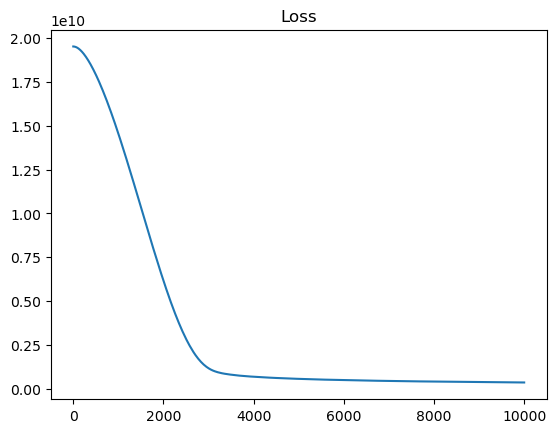

In [60]:
plt.plot(reg['regressor'].loss_curve_)
plt.title("Loss")
plt.show()

r^2:  0.8865117665550624
rmse : 26753.435204885172
rmsle : 0.12329257661722436
mae : 14704.08279628348


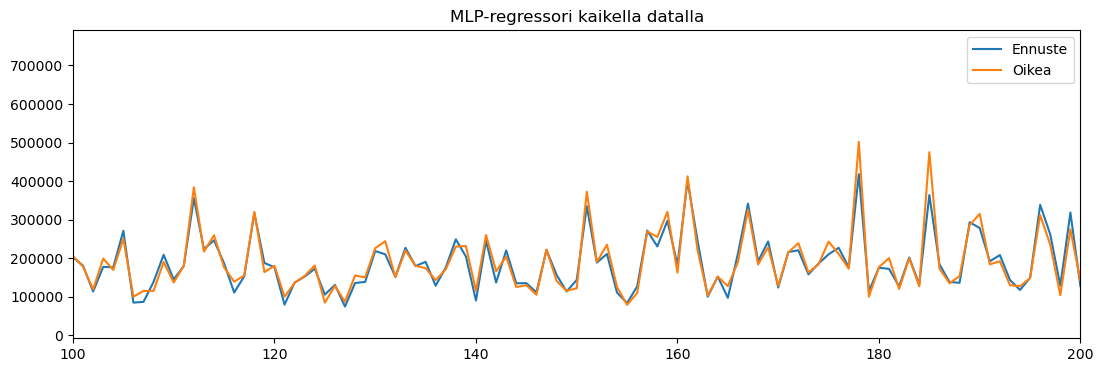

In [61]:
y_pred = pd.DataFrame(
    reg.predict(X)
)

Calculate_scores(y, y_pred)

figsize = (13, 4)
fig, ax = plt.subplots(figsize=figsize)

y_pred.plot(ax=ax)
y.plot(ax=ax)
ax.legend(["Ennuste", "Oikea"])
ax.set(xlim=[100, 200])
plt.title("MLP-regressori kaikella datalla")
plt.show()

MLP-regressori antoi oikean suuntaisia tuloksia, mutta ilman hyperparametrien säätöä tulos on huonompi
kuin XGB-regressorilla

# MLP-regressori #1 varsinainen ajo train- ja testdatalla 

Neuroneille on olemassa nyrkkisääntöjä kuten 

input > neuroneita > output

ja

neuroneita = 2/3 * input + output

Kokeillaan ensin 2/3:lla

In [62]:
# Näyttäisi toimivan, fitataan nyt train datalla ja kokeillaan saada hyvä test-ennuste

# https://medium.com/geekculture/introduction-to-neural-network-2f8b8221fbd3

# MLPRegressor uses train_test_split internally to create the validation data. 
# If shuffle argument to the MLPRegressor is set to false then the fraction is taken from the end of the test data.
# If the shuffle is set to true then the data is randomly selected. 
#
# Ts. annetaan MLPregressorille koko aineisto X ja validation_fraction = 0.2, shuffle=false, niin sen pitäisi jakaa data samoin kuin jaoimme manuaalisesti aiemmin.
# Ongelmana on, että jos pipelineen syöttää koko aineiston, ilmenee datavuotoa mm. skaalauksessa.
# Malli kuitenkin suoriutui huonommin, kun aineistoa pilkottiin lisää.
# Annetaan siis Regressorin ottaa koko aineistosta validointiaineisto (20%)
# Pienennetään samalla tolerancea, ettei malli lopeta opettelua liian aikaisin 1e-4 -> 1e-9.

reg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor',  MLPRegressor(
                          random_state=1,
                          max_iter=100000,
                          early_stopping=True,
                          hidden_layer_sizes=(int(len(X_train.columns) * 2 / 3)),
                          validation_fraction=0.2,
                          shuffle=False,
                          tol=1e-9,
                          n_iter_no_change=50))])

reg.fit(X, y)

column_names = reg[:1].get_feature_names_out()

In [63]:
plt.plot(reg['regressor'].loss_curve_)
plt.title("Loss")
plt.show()

r^2:  0.8241268082822139
rmse : 34340.86107573477
rmsle : 0.13136277463901574
mae : 16502.590692986952


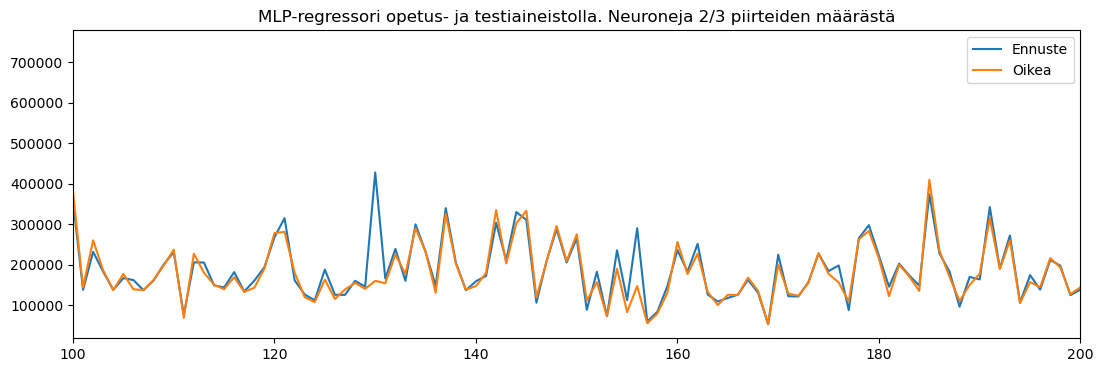

In [64]:
y_pred = pd.DataFrame(
    reg.predict(X_test)
)

Calculate_scores(y_test, y_pred)

figsize = (13, 4)
fig, ax = plt.subplots(figsize=figsize)

y_pred.plot(ax=ax)
y_test.plot(ax=ax)
ax.legend(["Ennuste", "Oikea"])
ax.set(xlim=[100, 200])
plt.title("MLP-regressori opetus- ja testiaineistolla. Neuroneja 2/3 piirteiden määrästä")
plt.show()

Verrataan XGB-regressoriin

r^2:  0.8241268082822139
rmse : 34340.86107573477
rmsle : 0.13136277463901574
mae : 16502.590692986952


[]

<Figure size 640x480 with 0 Axes>

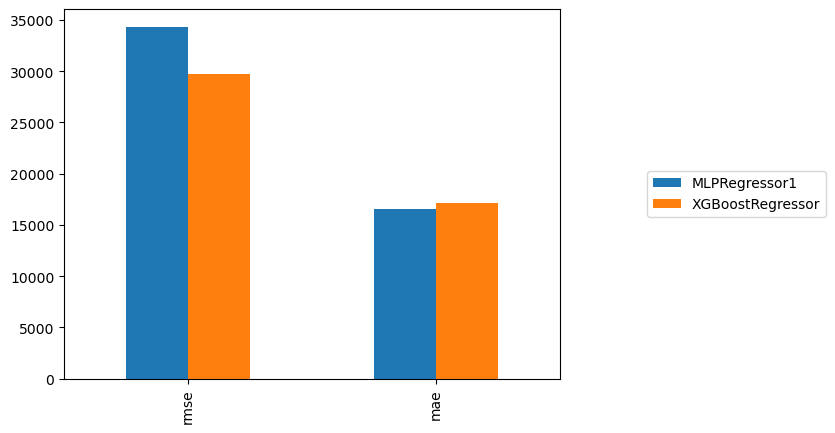

In [65]:
df_results1 = pd.DataFrame(Calculate_scores(y_test, y_pred), columns=['MLPRegressor1'])

df_results = pd.concat([df_results1,
                        pd.DataFrame(baseline_scores, columns=['XGBoostRegressor'])],
                       axis=1)

df_results.index = ['r2', 'rmse', 'rmsle', 'mae']
plt.figure()
_= df_results.loc[['rmse', 'mae']].plot.bar().legend(loc='center right', bbox_to_anchor=(1.55, 0.5))
plt.plot()
plt.figure()
_= df_results.loc['r2'].plot.bar().legend(loc='center right', bbox_to_anchor=(1.55, 0.5))
plt.plot()
plt.figure()
_= df_results.loc['rmsle'].plot.bar().legend(loc='center right', bbox_to_anchor=(1.55, 0.5))
plt.plot()

Eri arviointimenetelmät antavat joko parempia tai huonompia pisteitä verratuna XGB-regressoriin, joten mallit ovat nyt varmaan suhteellisen vertailukelpoisia.
Hyperparametrejä säätämällä saataneen tulosta paremmaksi.

# MLP-regressori #2

Neuroneja puolet piirteistä

In [66]:
# Kokeillaan neuronien määrä input/output-keskiarvolla

reg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor',  MLPRegressor(
                          random_state=1,
                          max_iter=100000,
                          early_stopping=True,
                          hidden_layer_sizes=(int((len(X_train.columns) + 1) / 2)),
                          validation_fraction=0.2,
                          shuffle=False,
                          tol=1e-9,
                          n_iter_no_change=50))])

reg.fit(X, y)

column_names = reg[:1].get_feature_names_out()

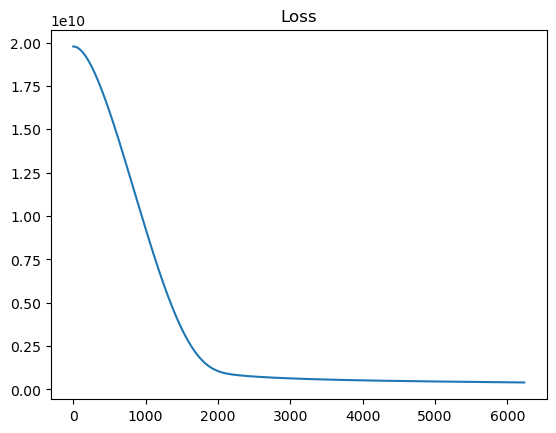

In [67]:
plt.plot(reg['regressor'].loss_curve_)
plt.title('Loss')
plt.show()

r^2:  0.7569923799074437
rmse : 40366.519410294735
rmsle : 0.16348951728102762
mae : 19036.520083544674


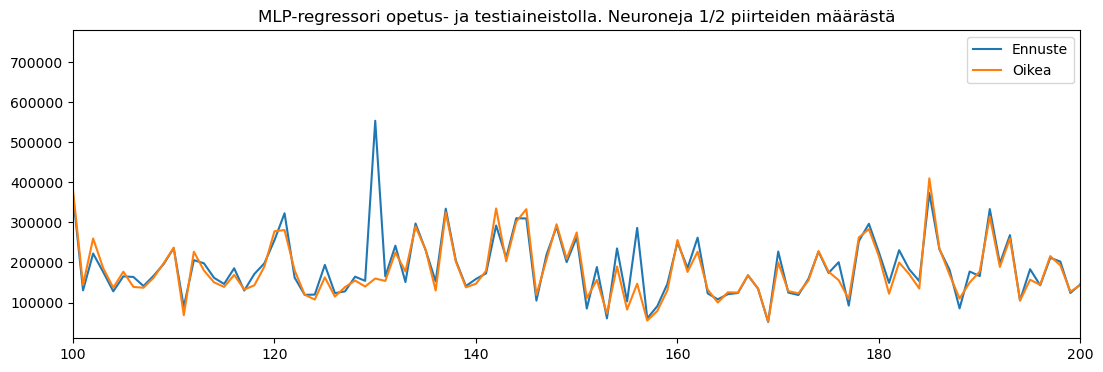

In [68]:
y_pred = pd.DataFrame(
    reg.predict(X_test)
)

Calculate_scores(y_test, y_pred)

figsize = (13, 4)
fig, ax = plt.subplots(figsize=figsize)

y_pred.plot(ax=ax)
y_test.plot(ax=ax)
ax.legend(["Ennuste", "Oikea"])
ax.set(xlim=[100, 200])
plt.title("MLP-regressori opetus- ja testiaineistolla. Neuroneja 1/2 piirteiden määrästä")
plt.show()

r^2:  0.7569923799074437
rmse : 40366.519410294735
rmsle : 0.16348951728102762
mae : 19036.520083544674


[]

<Figure size 640x480 with 0 Axes>

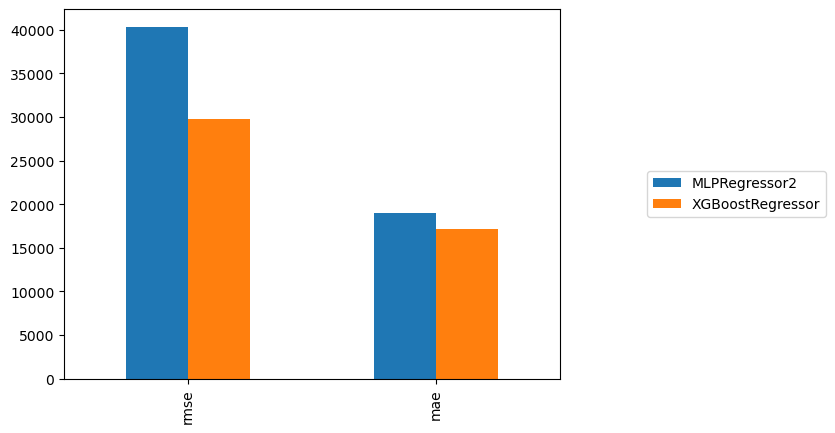

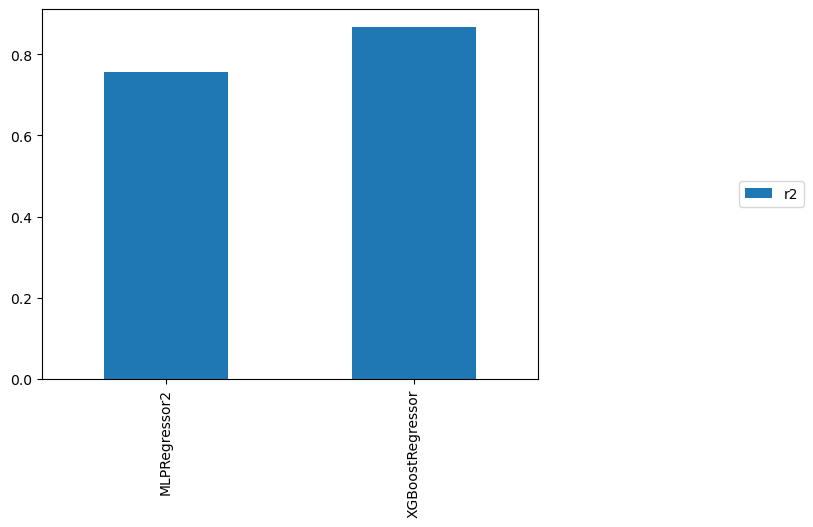

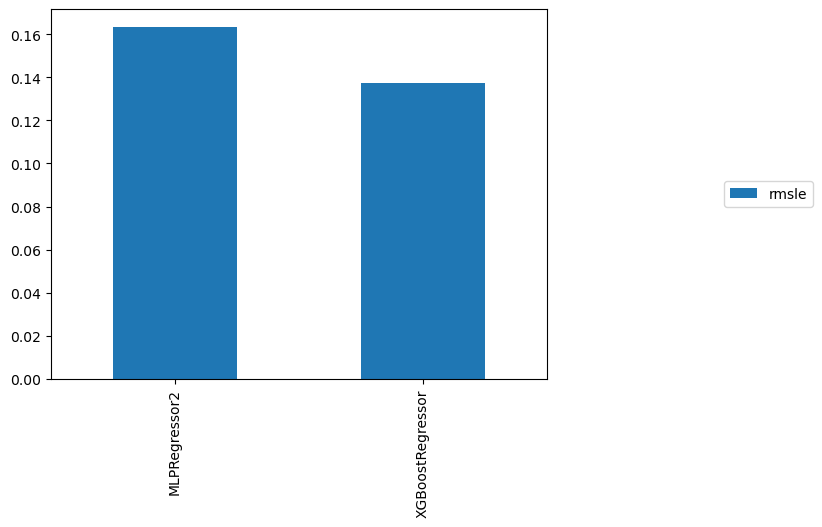

In [69]:
df_results2 = pd.DataFrame(Calculate_scores(y_test, y_pred), columns=['MLPRegressor2'])

df_results = pd.concat([df_results2,
                        pd.DataFrame(baseline_scores, columns=['XGBoostRegressor'])],
                       axis=1)

df_results.index = ['r2', 'rmse', 'rmsle', 'mae']
plt.figure()
_= df_results.loc[['rmse', 'mae']].plot.bar().legend(loc='center right', bbox_to_anchor=(1.55, 0.5))
plt.plot()
plt.figure()
_= df_results.loc['r2'].plot.bar().legend(loc='center right', bbox_to_anchor=(1.55, 0.5))
plt.plot()
plt.figure()
_= df_results.loc['rmsle'].plot.bar().legend(loc='center right', bbox_to_anchor=(1.55, 0.5))
plt.plot()

Tulos huononi huomattavasti, joten neuronien määrän valitsemisessa mentiin väärään suuntaan

# MLP-regressori #3

Neuroneita sama määrä kuin piirteitä

In [70]:
# Tulos huononi, joten kokeillaan jos neuronien määrä on inputtien määrä
reg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor',  MLPRegressor(
                          random_state=1,
                          max_iter=100000,
                          early_stopping=True,
                          hidden_layer_sizes=((len(X_train.columns))),
                          validation_fraction=0.2,
                          shuffle=False,
                          tol=1e-9,
                          n_iter_no_change=50))])

reg.fit(X, y)

column_names = reg[:1].get_feature_names_out()

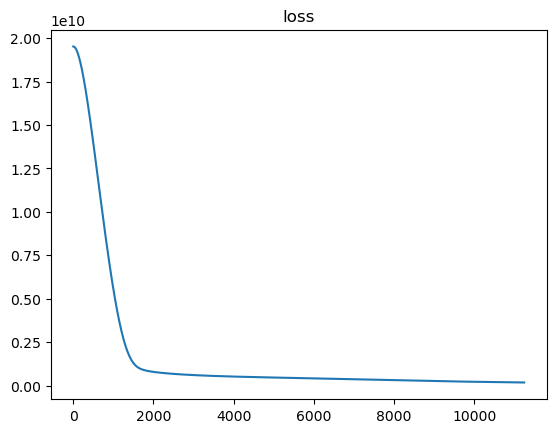

In [71]:
plt.plot(reg['regressor'].loss_curve_)
plt.title('loss')
plt.show()

r^2:  0.9367040778835887
rmse : 20601.51807525978
rmsle : 0.10002356319193434
mae : 12256.925245192011


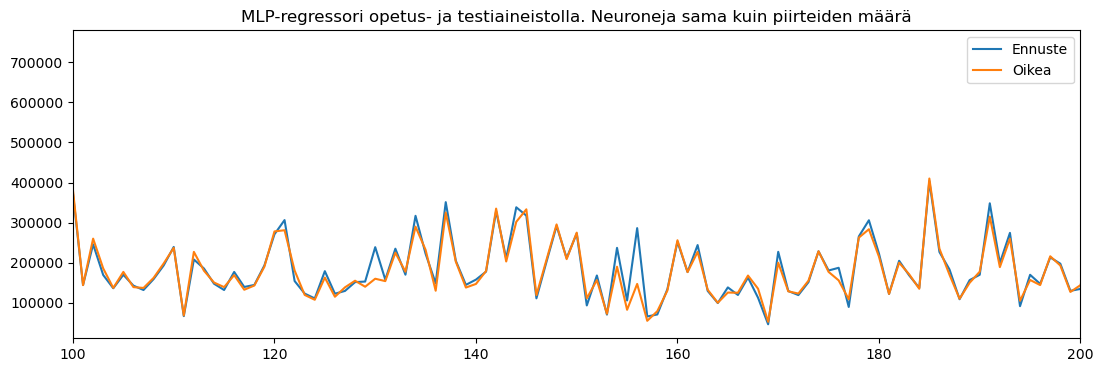

In [72]:
y_pred = pd.DataFrame(
    reg.predict(X_test)
)

Calculate_scores(y_test, y_pred)

figsize = (13, 4)
fig, ax = plt.subplots(figsize=figsize)

y_pred.plot(ax=ax)
y_test.plot(ax=ax)
ax.legend(["Ennuste", "Oikea"])
ax.set(xlim=[100, 200])
plt.title("MLP-regressori opetus- ja testiaineistolla. Neuroneja sama kuin piirteiden määrä")
plt.show()

r^2:  0.9367040778835887
rmse : 20601.51807525978
rmsle : 0.10002356319193434
mae : 12256.925245192011


[]

<Figure size 640x480 with 0 Axes>

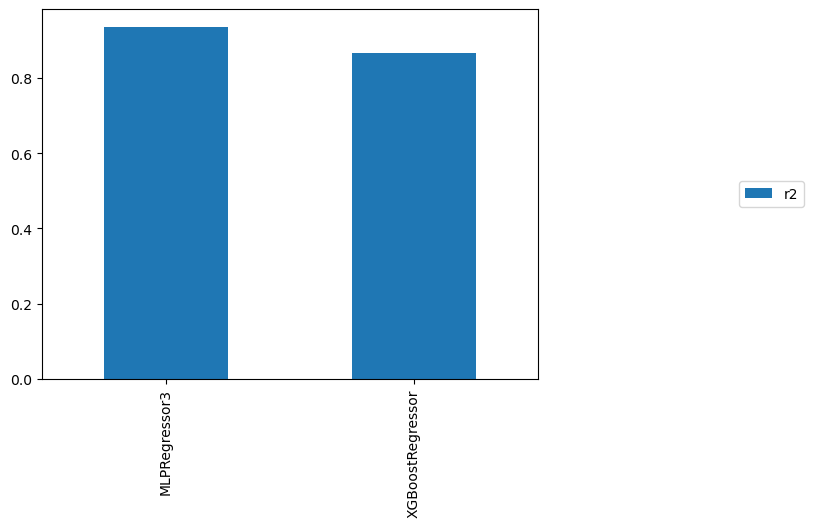

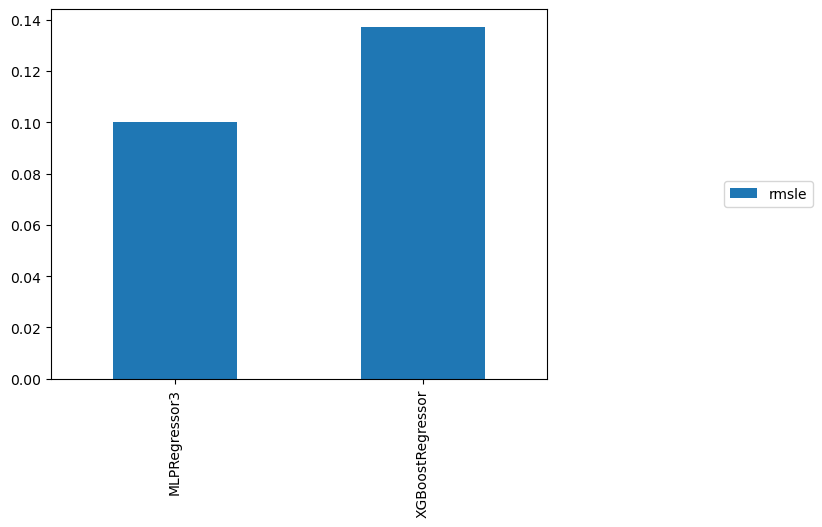

In [73]:
df_results3 = pd.DataFrame(Calculate_scores(y_test, y_pred), columns=['MLPRegressor3'])

df_results = pd.concat([df_results3,
                        pd.DataFrame(baseline_scores, columns=['XGBoostRegressor'])],
                       axis=1)

df_results.index = ['r2', 'rmse', 'rmsle', 'mae']
plt.figure()
_= df_results.loc[['rmse', 'mae']].plot.bar().legend(loc='center right', bbox_to_anchor=(1.55, 0.5))
plt.plot()
plt.figure()
_= df_results.loc['r2'].plot.bar().legend(loc='center right', bbox_to_anchor=(1.55, 0.5))
plt.plot()
plt.figure()
_= df_results.loc['rmsle'].plot.bar().legend(loc='center right', bbox_to_anchor=(1.55, 0.5))
plt.plot()

Tulos on reilusti parempi kuin XGB-regressorilla.

# MLP-regressori #4

Alpha-regularisaatio arvon kasvatus 0.0001 -> 0.001 overfittaamisen estämiseksi

In [74]:
# Kasvatetaan alphaa 0.0001 -> 0.001
reg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor',  MLPRegressor(
                          random_state=1,
                          max_iter=100000,
                          early_stopping=True,
                          hidden_layer_sizes=((len(X_train.columns))),
                          validation_fraction=0.2,
                          shuffle=False,
                          tol=1e-9,
                          n_iter_no_change=50,
                          alpha=0.001))])

reg.fit(X, y)

column_names = reg[:1].get_feature_names_out()

In [75]:
plt.plot(reg['regressor'].loss_curve_)
plt.title('loss')
plt.show()

r^2:  0.9423502813213411
rmse : 19661.19697680213
rmsle : 0.09676348305779223
mae : 11760.659620105687


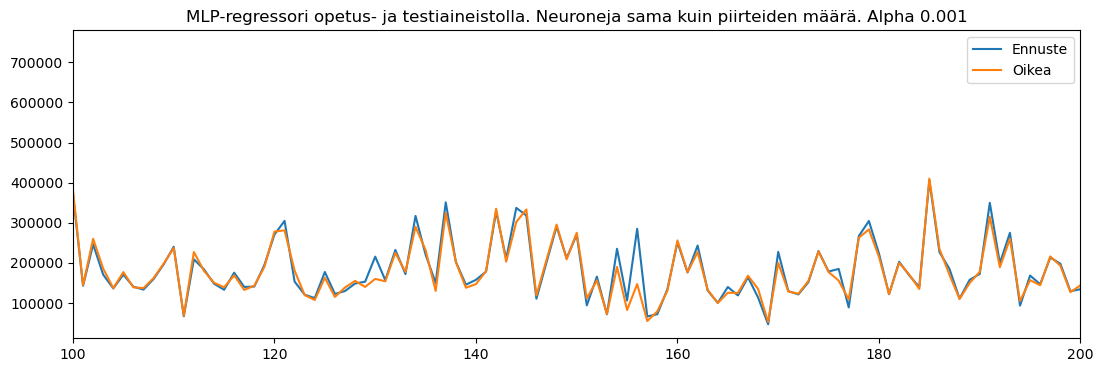

In [76]:
y_pred = pd.DataFrame(
    reg.predict(X_test)
)

Calculate_scores(y_test, y_pred)

figsize = (13, 4)
fig, ax = plt.subplots(figsize=figsize)

y_pred.plot(ax=ax)
y_test.plot(ax=ax)
ax.legend(["Ennuste", "Oikea"])
ax.set(xlim=[100, 200])
plt.title("MLP-regressori opetus- ja testiaineistolla. Neuroneja sama kuin piirteiden määrä. Alpha 0.001")
plt.show()

r^2:  0.9423502813213411
rmse : 19661.19697680213
rmsle : 0.09676348305779223
mae : 11760.659620105687


[]

<Figure size 640x480 with 0 Axes>

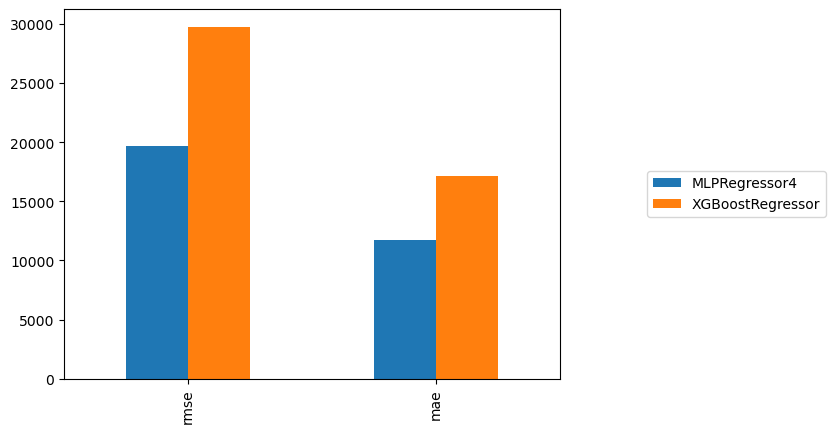

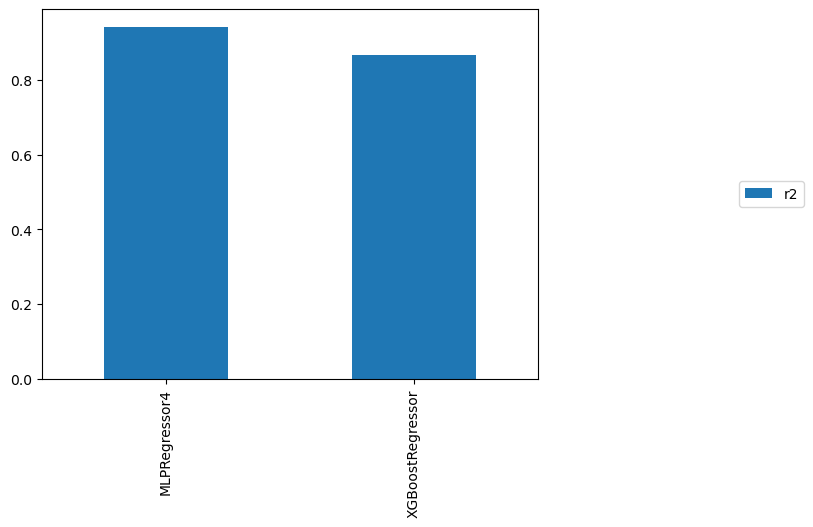

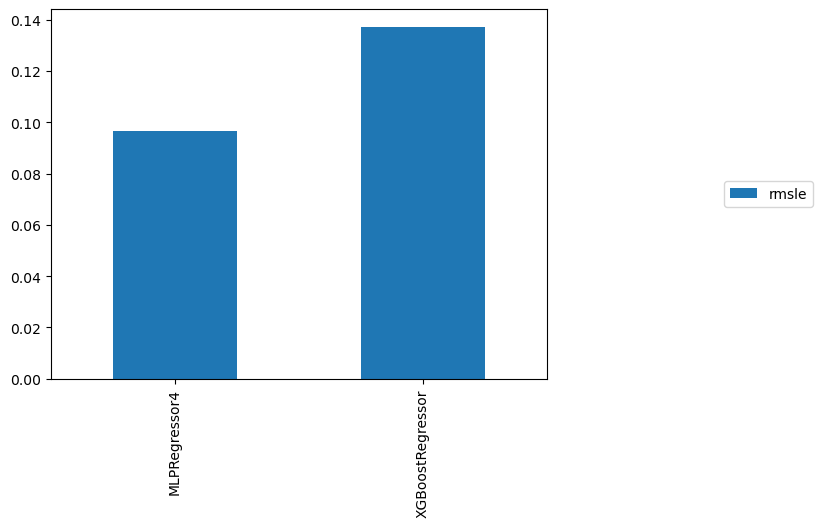

In [77]:
df_results4 = pd.DataFrame(Calculate_scores(y_test, y_pred), columns=['MLPRegressor4'])

df_results = pd.concat([df_results4,
                        pd.DataFrame(baseline_scores, columns=['XGBoostRegressor'])],
                       axis=1)

df_results.index = ['r2', 'rmse', 'rmsle', 'mae']
plt.figure()
_= df_results.loc[['rmse', 'mae']].plot.bar().legend(loc='center right', bbox_to_anchor=(1.55, 0.5))
plt.plot()
plt.figure()
_= df_results.loc['r2'].plot.bar().legend(loc='center right', bbox_to_anchor=(1.55, 0.5))
plt.plot()
plt.figure()
_= df_results.loc['rmsle'].plot.bar().legend(loc='center right', bbox_to_anchor=(1.55, 0.5))
plt.plot()

Tulokset paranivat, joten regularisaatio-parametrin kasvatus auttoi.

# Tulosten visualisointi

[]

<Figure size 640x480 with 0 Axes>

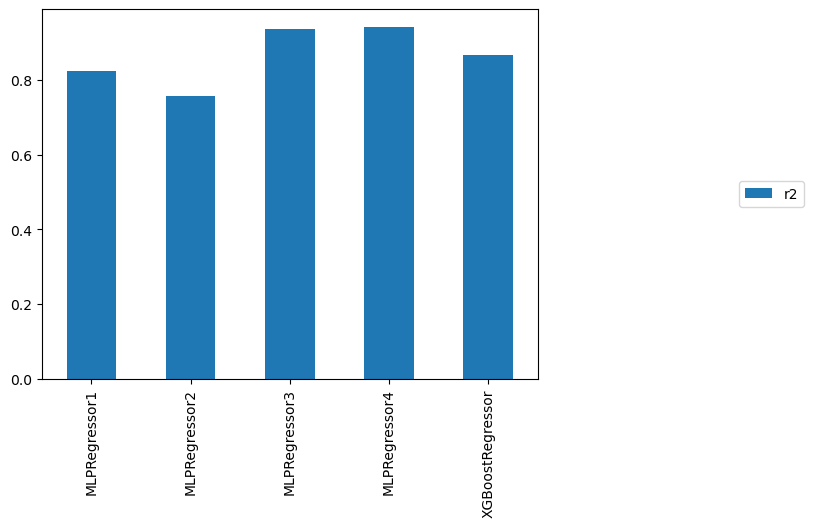

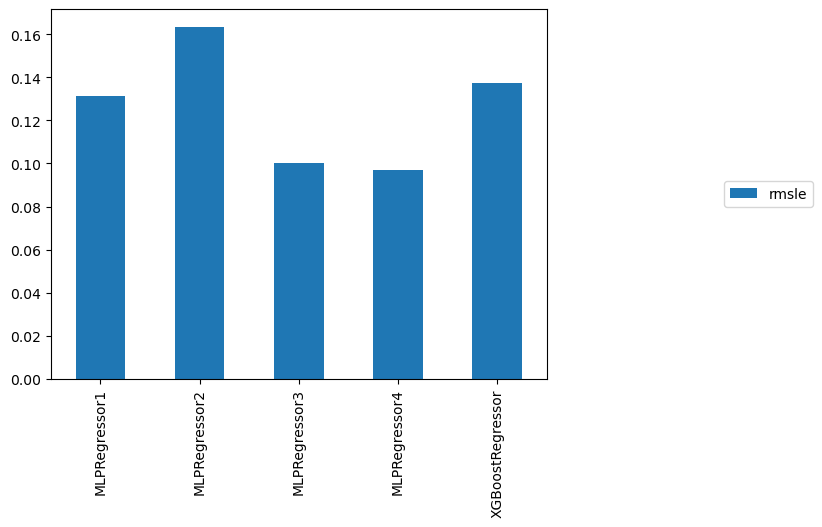

In [78]:
df_results = pd.concat([df_results1,
                        df_results2,
                        df_results3,
                        df_results4,
                        pd.DataFrame(baseline_scores, columns=['XGBoostRegressor'])],
                       axis=1)

df_results.index = ['r2', 'rmse', 'rmsle', 'mae']
plt.figure()
_= df_results.loc[['rmse', 'mae']].plot.bar().legend(loc='center right', bbox_to_anchor=(1.55, 0.5))
plt.plot()
plt.figure()
_= df_results.loc['r2'].plot.bar().legend(loc='center right', bbox_to_anchor=(1.55, 0.5))
plt.plot()
plt.figure()
_= df_results.loc['rmsle'].plot.bar().legend(loc='center right', bbox_to_anchor=(1.55, 0.5))
plt.plot()

# Pohdinta

XGB-regressori on erittäin suosittu varsinkin Kagglessa erinäisten koneoppimisongelmien ratkaisuun, koska se pystyy ratkomaan useat ongelmat hyvin jo pelkillä oletusarvoilla ja nopeasti. MLP-regressorin sai kuitenkin suoriutumaan paremmin hyperparametrejä säätämällä, mutta sen suoritusaika oli huonoimmillaan jopa tuhatkertainen ellei enemmänkin.

Mallien toimivuutta voisi parantaa hakemalla vielä paremmat hyperparametrit mahdollisesti jonkun automaattisen työkalun avulla ja antamalla mallin fitata pitempään. Lisäksi piirteitä pitäisi tutkia tarkemmin, koska niistä saattaisi pystyä tekemään johdannaispiirteitä, jotka avustavat mallia sopeutumaan nopeammin ja/tai tarkemmin. Outlierit ovat ongelmallisia, sillä ne vaikuttavat mm. StandardScaleriin huomattavasti, mutta toisaalta niitä ei voi suoraan poistaakaan, koska ne saattavat tuoda tärkeää lisätietoa.  

Mallien kuvaajissa näkyi muutamia suuria virhepiikkejä tiettyjen talojen kohdalla. Näiden tutkiminen voisi tuoda lisäinfoa piirteistä.

Useissa piirteissä kuvataan nollalla, että sitä ei ole. Näistä voisi tehdä uusia piirteitä kertomaan onko vai eikö ole ominaisuutta, jos sitä ei ole vielä.

# Extraa: Ennustuksen syöttö Kagglen arviointia ja tulostaulukkoa varten

### test.csv:n luku

In [79]:
# Testataan test-datalla Kagglea varten

dir = 'house-prices-advanced-regression-techniques'

test_data = pd.read_csv(dir + '/test.csv', header=0)

# Poistetaan Id-piirre
X_2 = test_data.drop(columns='Id')

# Muuten sama rakenne  kuin train.csv:ssä, mutta ilman kohdemuuttujaa
X_2.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          20       RH         80.0    11622   Pave   NaN      Reg   
1          20       RL         81.0    14267   Pave   NaN      IR1   
2          60       RL         74.0    13830   Pave   NaN      IR1   
3          60       RL         78.0     9978   Pave   NaN      IR1   
4         120       RL         43.0     5005   Pave   NaN      IR1   

  LandContour Utilities LotConfig  ... ScreenPorch PoolArea PoolQC  Fence  \
0         Lvl    AllPub    Inside  ...         120        0    NaN  MnPrv   
1         Lvl    AllPub    Corner  ...           0        0    NaN    NaN   
2         Lvl    AllPub    Inside  ...           0        0    NaN  MnPrv   
3         Lvl    AllPub    Inside  ...           0        0    NaN    NaN   
4         HLS    AllPub    Inside  ...         144        0    NaN    NaN   

  MiscFeature MiscVal  MoSold  YrSold  SaleType  SaleCondition  
0         NaN       0       6    2010        WD         Normal  
1        Gar2   12500       6    2010        WD         Normal  
2         NaN       0       3    2010        WD         Normal  
3         NaN       0       6    2010        WD         Normal  
4         NaN       0       1    2010        WD         Normal  

[5 rows x 79 columns]

In [80]:
# Pipeline on valmiina, joten antaa mennä vain

y_pred = pd.concat([test_data['Id'],
                    pd.DataFrame(reg.predict(X_2), columns=['SalePrice'])],
                   axis=1
)
y_pred.index += 1

### Ennustaminen

In [81]:
y_pred.head()

Id      SalePrice
1  1461  120344.577632
2  1462  109223.748561
3  1463  186075.817950
4  1464  189688.320582
5  1465  202525.912268

### Tulokset csv-muotoon

In [82]:
# Write to csv
#y_pred.to_csv('submission_alpha.csv', index=False)

# Tulokset Kagglesta
[Linkki Leaderboard-jakaumaan](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/discussion/400866)

![Pisteet](img/kaggle.png)

![Jakauma](img/kaggle_leaderboard.png)

Jotakin on tehty oikein, kun ison joukon mukaan päästiin, mutta sijoitus on hieman kellokäyrän huonommalla puolella, eli parannettavaa löytyy vielä paljon